```{post} 21 August, 2021
:author: Brodie Blackburn
```

# Calculate the knee point voltage of a current transformer algorithmically

## Current transformers

A [current transformer](https://en.wikipedia.org/wiki/Current_transformer) (CT) is used to measure current in power systems. Current in a CT's primary winding is transformed to a smaller current in its secondary winding. Measuring instruments can safely handle smaller currents.

A CT operates according to the principles of [electromagnetic induction](https://en.wikipedia.org/wiki/Electromagnetic_induction): 

- The primary winding current has an associated magnetic field.
- The magnetic field is concentrated in the CT's [magnetic core](https://en.wikipedia.org/wiki/Magnetic_core), around which the secondary is wound.
- In alternating current (AC) power systems, the primary winding's current is time-varying.
- So too are its magnetic field and [magnetic flux](https://en.wikipedia.org/wiki/Magnetic_flux) through the [*surface*](https://commons.wikimedia.org/wiki/File:Spulenflaeche.jpg) enclosed by the secondary winding.
- The changing magnetic flux induces an electromotive force (emf) in the secondary winding.
- Induced current flows if the secondary winding forms part of a circuit.

CTs are designed to have an accurate ratio between primary and secondary currents over some defined range of currents. Beyond this range, a CT's magnetic core [saturates](https://en.wikipedia.org/wiki/Saturation_%28magnetic%29): the magnetic flux through the secondary winding is no longer proportional to the primary current.

## Knee point voltage

We can see the effects of saturation by applying a voltage across a CT's secondary terminals and measuring the current. (The secondary is used so that test currents are more manageable.) The voltage and current will have a linear (proportional) relationship up to a point, the knee point. The IEC [defines](https://www.electropedia.org/iev/iev.nsf/display?openform&ievref=321-02-34) knee point voltage to be the voltage at which a 10% increase in applied voltage results in a 50% increase in exciting current. 

A CT's [knee point voltage](https://en.wikipedia.org/wiki/Current_transformer#Knee-point_core-saturation_voltage) is an important property to consider in the design of power system [protection schemes](https://en.wikipedia.org/wiki/Protective_relay), where fault currents can be many times rated current. 

Specialised test equipment can be used to determine a CT's knee point voltage automatically. It does this by iteratively adjusting applied voltage until it converges on a point that satisfies the definition.

Sometimes, however, we may have to determine the knee point voltage ourselves. The CT in question may already be in service. CT test data might exist only in a scanned report from the 1980s.

It would be nice to have a method to determine the knee point voltage algorithmically rather than "eyeballing it".

## Test data

Here's some CT test data. I've used Python [tuples](https://docs.python.org/3.8/library/stdtypes.html#tuples) to hold applied voltages ($ V $) and measured currents ($ I $).

In [1]:
# EAAY C196 2S1-2S5 measurements
i_data = 0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0
v_data = 175, 440, 800, 925, 970, 990, 1020, 1050

Let's visualise the data with [Matplotlib](https://matplotlib.org).

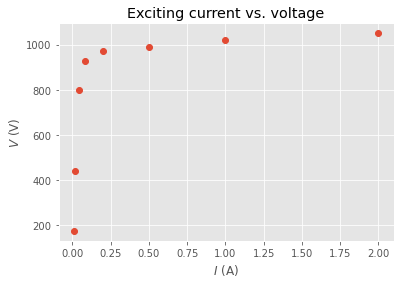

In [2]:
from matplotlib import pyplot

# Set style, labels and title.
pyplot.style.use('ggplot')
pyplot.xlabel('$I$ (A)')
pyplot.ylabel('$V$ (V)')
pyplot.title('Exciting current vs. voltage')
# Plot measurements.
pyplot.plot(i_data, v_data, 'o');

## Modelling

The knee point voltage definition (where a 10% increase in $ V $ results in 50% increase in $ I $) can be represented as an equation:

$$ 1.1 \cdot V(I) = V(1.5 \cdot I) $$

If we had some function $ V(I) $ that approximated the test data, we could find the knee point voltage by solving the equation. We want to fit a *model* to the data. 

[This paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9031356) covers some established simple models of magnetization curves:

- Simple exponential
- Froelich's equation
- Inverse tangent

Of the simple models, the authors found the inverse tangent model to most accurately fit their data. So I decided to use it. You can get a feel for the model by adjusting its parameters [here](https://www.desmos.com/calculator/pm1ibzx0if).

$$ V(I) = a \cdot \tan^{-1}(b \cdot I) $$

## Curve fitting

Let's fit the model to our data. We can use SciPy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) function. `curve_fit` returns parameters that best fit a given function to data. 

We'll start by defining a Python function `v` that implements the inverse tangent mathematical model.

In [3]:
# Inverse tangent model
v = lambda i, a, b: a * np.arctan(b * i)

By default, `curve_fit` does not impose bounds on parameter values. We can "help" `curve_fit` by providing bounds. We are not interested in curves where $ a $ or $ b $ are negative, so we set the lower bounds of $ a $ and $ b $ to 0. (The upper bounds are left unbounded.)

In [4]:
import numpy as np
import scipy.optimize

# Find parameters of v that best fit the data.
popt, _ = scipy.optimize.curve_fit(
    v, i_data, v_data, bounds=(0, np.inf),
)

Let's plot the model and data.

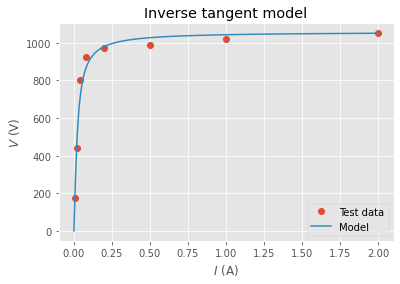

In [5]:
# Create values between min and max measured current.
# Values are log spaced for better vertical curve resolution.
i = np.geomspace(min(i_data), max(i_data))
# Plot the origin too.
i = np.insert(i, 0, 0)

pyplot.plot(i_data, v_data, 'o', label='Test data')
pyplot.plot(i, v(i, *popt), label='Model')
pyplot.xlabel('$I$ (A)')
pyplot.ylabel('$V$ (V)')
pyplot.title('Inverse tangent model')
pyplot.legend();

The model looks like a reasonable fit.

## Find the knee point

We have a continuous function, $ V(I) $, that models the CT's test response. To find the knee point, we need to solve the equation for $ I $. We'll rearrange the original equation so that it is equal to 0:

$$ F(I) = 1.1 \cdot V(I) - V(1.5 \cdot I) = 0 $$

Now we can find its [root](https://en.wikipedia.org/wiki/Zero_of_a_function) between the bounds of our data.

We can use SciPy's [`brentq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) function for this. It works by looking for a change in sign of the given function over some range. 

Let's define another Python function `f` that implements this equation.

In [6]:
f = lambda i: 1.1 * v(i, *popt) - v(1.5 * i, *popt)

We'll find the knee point using `brentq` on this new function over the range of the data.

In [7]:
i_knee_point = scipy.optimize.brentq(f, min(i_data), max(i_data))

The knee point voltage is simply the value of the model function at the knee point. 

In [8]:
v_knee_point = v(i_knee_point, *popt)

We'll modify the previous plot to show the knee point.

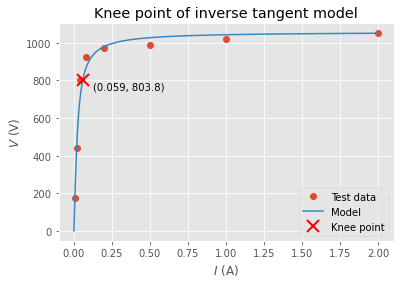

In [9]:
pyplot.plot(i_data, v_data, 'o', label='Test data')
pyplot.plot(i, v(i, *popt), label='Model')
pyplot.plot(i_knee_point, v_knee_point, color='red', marker='x', 
          markersize=12, markeredgewidth=2, linewidth=0, 
          label='Knee point')
pyplot.annotate(f'({i_knee_point:.3f}, {v_knee_point:0.1f})', 
                (i_knee_point, v_knee_point), xytext=(10, -10), 
                textcoords='offset points')
pyplot.xlabel('$I$ (A)')
pyplot.ylabel('$V$ (V)')
pyplot.title('Knee point of inverse tangent model')
pyplot.legend();

## Layers of abstraction

We've done some work to find the knee point of one set of test data. It would be nice to create an approach that generalises to other sets of test data.

Let's define a Python function `find_knee_point` that finds the knee point of given test data using the inverse tangent model.

In [10]:
def find_knee_point(i_data, v_data, v=lambda i, a, b: a * np.arctan(b * i)):
    """Returns the knee point (i, v) and model parameters that fit 
    given test data.
    
    By default, data is fit to the inverse tangent model, but you can 
    specify your own model.
    """
    # Find parameters of v that best fit the data.
    popt, _ = scipy.optimize.curve_fit(
        v, i_data, v_data, bounds=(0, np.inf),
    )
    # Equation for v(i) = 0.
    f = lambda i: 1.1 * v(i, *popt) - v(1.5 * i, *popt)
    # Find knee point.
    i_knee_point = scipy.optimize.brentq(f, min(i_data), max(i_data))
    v_knee_point = v(i_knee_point, *popt)
    
    return i_knee_point, v_knee_point, popt

I've got data from other CT tests. We can use `find_knee_point` on this data.

In [11]:
tests = (
    # Marvisfield =EA02-T03 (A496) mag curve data from old scanned test report.
    ((0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0),
     (150, 340, 800, 925, 975, 1000, 1020, 1040)),
    # Another CT
    ((0.075, 0.15, 0.2, 0.4, 0.8, 1, 2, 3, 5),
     (240, 480, 490, 530, 550, 555, 570, 580, 590)),
    # Some other CT
    ((0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1, 1.5, 2, 2.5, 3),
     (95, 194, 370, 420, 442, 465, 475, 478, 482, 489, 492, 495, 500, 509, 511, 514)),
)

Let's plot the knee points of all tests.

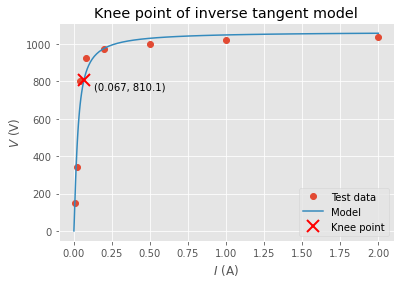

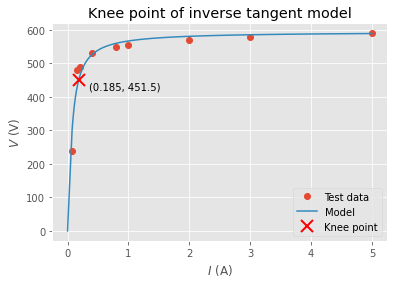

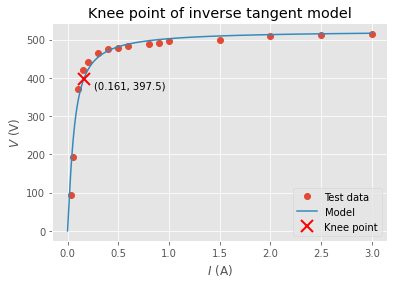

In [12]:
v = lambda i, a, b: a * np.arctan(b * i)

for i_data, v_data in tests:
    i_knee_point, v_knee_point, popt = find_knee_point(i_data, v_data)
    i = np.geomspace(min(i_data), max(i_data))
    i = np.insert(i, 0, 0)
    pyplot.plot(i_data, v_data, 'o', label='Test data')
    pyplot.plot(i, v(i, *popt), label='Model')
    pyplot.plot(i_knee_point, v_knee_point, color='red', marker='x', 
              markersize=12, markeredgewidth=2, linewidth=0, 
              label='Knee point')
    pyplot.annotate(f'({i_knee_point:.3f}, {v_knee_point:0.1f})', 
                    (i_knee_point, v_knee_point), xytext=(10, -10), 
                    textcoords='offset points')
    pyplot.xlabel('$I$ (A)')
    pyplot.ylabel('$V$ (V)')
    pyplot.title('Knee point of inverse tangent model')
    pyplot.legend()
    pyplot.show()

Nice!